In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
height = 1200
width = 1600

In [3]:
def getPoseFromDataframe(df):
    reshaped_poses = []
    for index, row in df.iterrows():
        matrix = row.values[1:].reshape(3, 3)
        reshaped_poses.append(matrix)
    
    ground_pose = np.array(reshaped_poses) @ np.array([height/2,width/2,1])
    ground_pose = np.array(reshaped_poses) @ np.array([0,0,1])
    # ground_pose = np.array(reshaped_poses)[:,:,2]
    # print(np.array(reshaped_poses).shape, ground_pose[0])
    return ground_pose

In [4]:
def arctan2_array(y_array, x_array):
    result = []
    for y, x in zip(y_array, x_array):
        result.append(math.atan2(y, x))
    return np.array(result)

In [5]:
def getTheta(df):
    y = np.array(df.values[:,4])
    x = np.array(df.values[:,1])

    try:
        ground_theta = np.arctan2(y,x)
    except:
        # print("Unable to use numpy")
        ground_theta = arctan2_array(y,x)
    return ground_theta

In [6]:
def getPoseTheta(file):
    df = pd.read_csv(file)
    ground_pose = getPoseFromDataframe(df)
    ground_theta = getTheta(df)
    return ground_pose, ground_theta

In [7]:
def getPoseNp(file):
    data = np.load(file)
    pose = data[:,:2]
    theta = data[:,2]
    return pose,theta

In [8]:
def plotResultsOnly(np_file, t=-1,save=False):
    est_pose, est_theta = getPoseNp(np_file)

    # Slice for subset of data
    if t>0:
        est_pose = est_pose[:t]
        est_theta = est_theta[:t]

    
    # Create subplots with 3 rows and 2 columns
    # fig, axs = plt.subplots(3, 2, figsize=(10, 12))
    fig, axs = plt.subplots( figsize=(10, 12))
    
    # Plot estimated pose (x, y)
    axs.plot(est_pose[:, 0], est_pose[:, 1], label='Estimated Pose', color='r')
    axs.set_title('Estimated Pose (x, y)')
    axs.set_xlabel('X')
    axs.set_ylabel('Y')
    axs.legend()
    axs.axis('equal') 
    axs.grid(True)

    """
    # Plot estimated pose (x, y)
    axs[0].plot(est_pose[:, 0], est_pose[:, 1], label='Estimated Pose', color='r')
    axs[0].set_title('Estimated Pose (x, y)')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].legend()
    axs[0].axis('equal') 

    # Plot estimated theta
    axs[1].plot(est_theta, label='Estimated Theta', color='r')
    axs[1].set_title('Estimated Theta')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Theta (radians)')
    axs[1].legend()
    
    # Unwrap and plot unwrapped theta
    unwrapped_est_theta = np.unwrap(est_theta)
        
    axs[2].plot(unwrapped_est_theta, label='Estimated Unwrapped Theta', color='r')
    axs[2].set_title('Estimated Unwrapped Theta')
    axs[2].set_xlabel('Index')
    axs[2].set_ylabel('Unwrapped Theta (radians)')
    axs[2].legend()

    """
    fig.suptitle(f'File {np_file[:-13]}', fontsize=10)
    # Adjust layout to avoid overlapping
    plt.tight_layout()
    if save:
        print(f"saving to file {np_file[:-4] + '.png'}")
        plt.savefig(np_file[:-4] + 'cropped.png')
    # Show the plots
    plt.show()
    

In [9]:
def transformEstimates(est_pose, csv_file):
    
    df = pd.read_csv(csv_file)
    tf = df.values[0][1:]
    tf = tf.reshape(3, 3)
    tf = tf.transpose()
    # est_pose *= 8782.83412
    tf[2,:2] /= 8782.83412
    est_pose = np.column_stack((est_pose, np.ones(est_pose.shape[0])))
    est_pose = est_pose @ tf
    return est_pose

In [10]:
def plotResults(csv_file, np_file, t=-1,save=False,show=True):

    ground_pose, ground_theta = getPoseTheta(csv_file)
    est_pose, est_theta = getPoseNp(np_file)

    est_pose = transformEstimates(est_pose, csv_file)
    est_theta += ground_theta[0]
    ground_pose[:,:2] = ground_pose[:,:2] /  np.array((8782.83412,8782.83412))
    
    # Slice for subset of data
    if t>0:
        ground_pose = ground_pose[:t]
        ground_theta = ground_theta[:t]
        est_pose = est_pose[:t]
        est_theta = est_theta[:t]

    
    # Create subplots with 3 rows and 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(10, 12))
    
    # Plot ground truth and estimated pose (x, y)
    axs[0, 0].plot(ground_pose[:, 0], ground_pose[:, 1], label='Ground Truth Pose', color='b')
    axs[0, 0].set_title('Ground Truth Pose (x, y)')
    axs[0, 0].set_xlabel('X')
    axs[0, 0].set_ylabel('Y')
    axs[0, 0].axis('equal') 
    axs[0, 0].legend()
    
    axs[0, 1].plot(est_pose[:, 0], est_pose[:, 1], label='Estimated Pose', color='r')
    axs[0, 1].set_title('Estimated Pose (x, y)')
    axs[0, 1].set_xlabel('X')
    axs[0, 1].set_ylabel('Y')
    axs[0, 1].axis('equal') 
    axs[0, 1].legend()
    
    # # Plot ground truth and estimated theta
    # axs[1, 0].plot(ground_theta, label='Ground Truth Theta', color='b')
    # axs[1, 0].set_title('Ground Truth Theta')
    # axs[1, 0].set_xlabel('Index')
    # axs[1, 0].set_ylabel('Theta (radians)')
    # axs[1, 0].legend()
    
    # axs[1, 1].plot(est_theta, label='Estimated Theta', color='r')
    # axs[1, 1].set_title('Estimated Theta')
    # axs[1, 1].set_xlabel('Index')
    # axs[1, 1].set_ylabel('Theta (radians)')
    # axs[1, 1].legend()
    
    # Unwrap and plot unwrapped theta
    unwrapped_ground_theta = np.unwrap(ground_theta)
    unwrapped_est_theta = np.unwrap(est_theta)
    
    axs[1, 0].plot(unwrapped_ground_theta, label='Ground Truth Unwrapped Theta', color='b')
    axs[1, 0].set_title('Ground Truth Unwrapped Theta')
    axs[1, 0].set_xlabel('Index')
    axs[1, 0].set_ylabel('Unwrapped Theta (radians)')
    axs[1, 0].legend()
    
    axs[1, 1].plot(unwrapped_est_theta, label='Estimated Unwrapped Theta', color='r')
    axs[1, 1].set_title('Estimated Unwrapped Theta')
    axs[1, 1].set_xlabel('Index')
    axs[1, 1].set_ylabel('Unwrapped Theta (radians)')
    axs[1, 1].legend()

    fig.suptitle(f'File {np_file}', fontsize=10)
    # Adjust layout to avoid overlapping
    plt.tight_layout()
    
    if save:
        plt.savefig(np_file[:-4] + 'cropped.png')

    if show:
        plt.show()

    plt.close()
    

In [44]:
def plotResults(csv_file, np_file, t=-1,save=False,show=True):

    ground_pose, ground_theta = getPoseTheta(csv_file)
    est_pose, est_theta = getPoseNp(np_file)

    est_pose = transformEstimates(est_pose, csv_file)
    est_theta += ground_theta[0]
    ground_pose[:,:2] = ground_pose[:,:2] /  np.array((8782.83412,8782.83412))
    
    # Slice for subset of data
    if t>0:
        ground_pose = ground_pose[:t]
        ground_theta = ground_theta[:t]
        est_pose = est_pose[:t]
        est_theta = est_theta[:t]
    
    # Create subplots with 3 rows and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot ground truth and estimated pose (x, y)
    axs[0].plot(ground_pose[:, 0], ground_pose[:, 1], label='Ground Truth Pose', color='b')
    axs[0].plot(est_pose[:, 0], est_pose[:, 1], label='Estimated Pose', color='r')
    axs[0].scatter(ground_pose[0, 0], ground_pose[0, 1], label='Starting position', marker='x', color='black')
    
    axs[0].set_title('Estimated Pose v/s Ground Truth (x, y)')
    axs[0].set_xlabel('X co-ordinte (meters)')
    axs[0].set_ylabel('Y co-ordinte (meters)')
    axs[0].axis('equal') 
    axs[0].legend()

    # Unwrap and plot unwrapped theta
    unwrapped_ground_theta = np.unwrap(ground_theta)
    unwrapped_est_theta = np.unwrap(est_theta)

    axs[1].plot(unwrapped_ground_theta, label='Ground Truth Unwrapped Theta', color='b')
    axs[1].plot(unwrapped_est_theta, label='Estimated Unwrapped Theta', color='r')
    axs[1].set_title('Estimated v/s Ground Theta Unwrapped')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Unwrapped Theta (radians)')
    axs[1].legend()
    
    fig.suptitle(getTitle(np_file[8:]), fontsize=10)
    # Adjust layout to avoid overlapping
    plt.tight_layout()
    
    if save:
        plt.savefig(np_file[:-4] + 'transformed.png')

    if show:
        plt.show()

    plt.close()
    

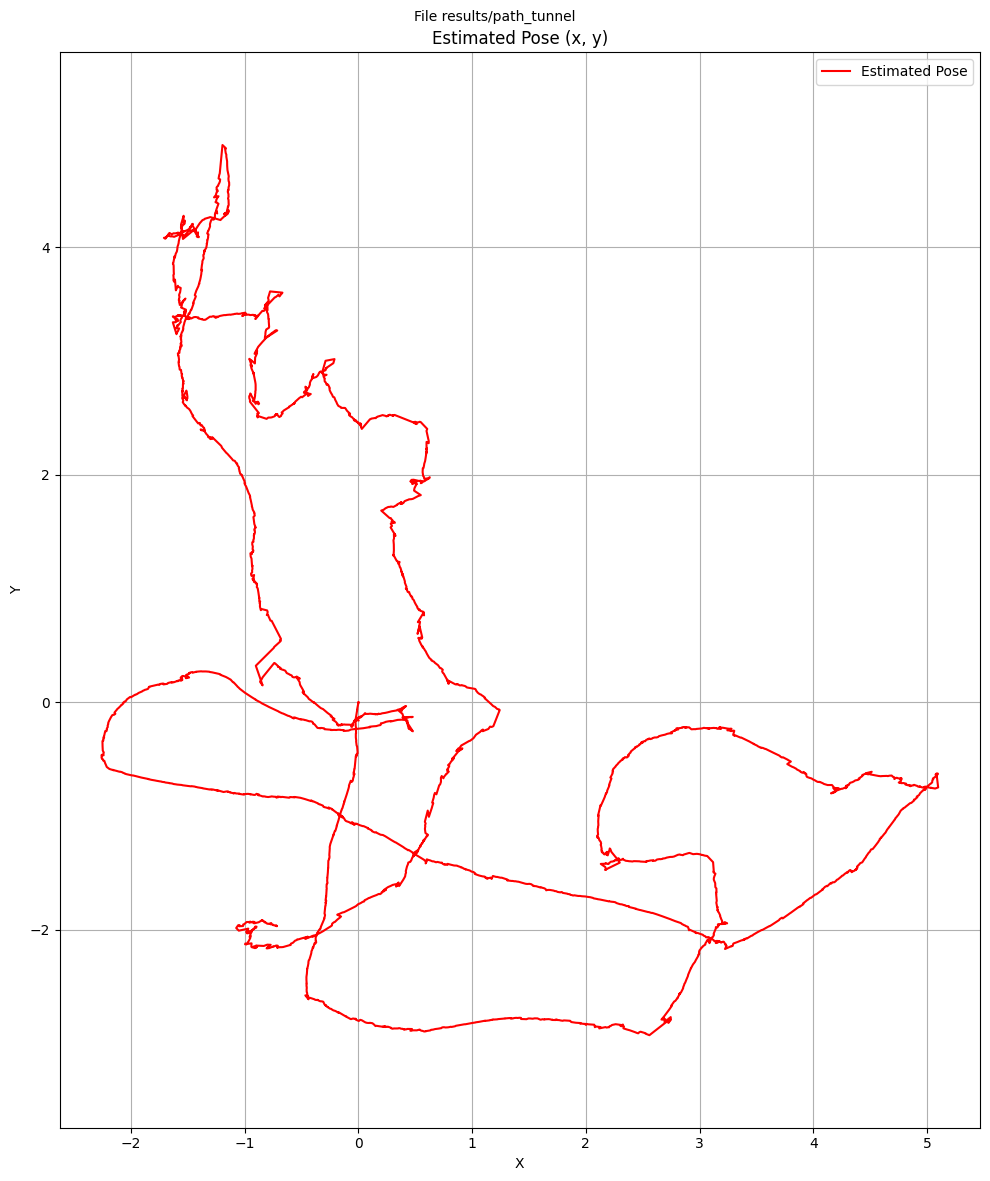

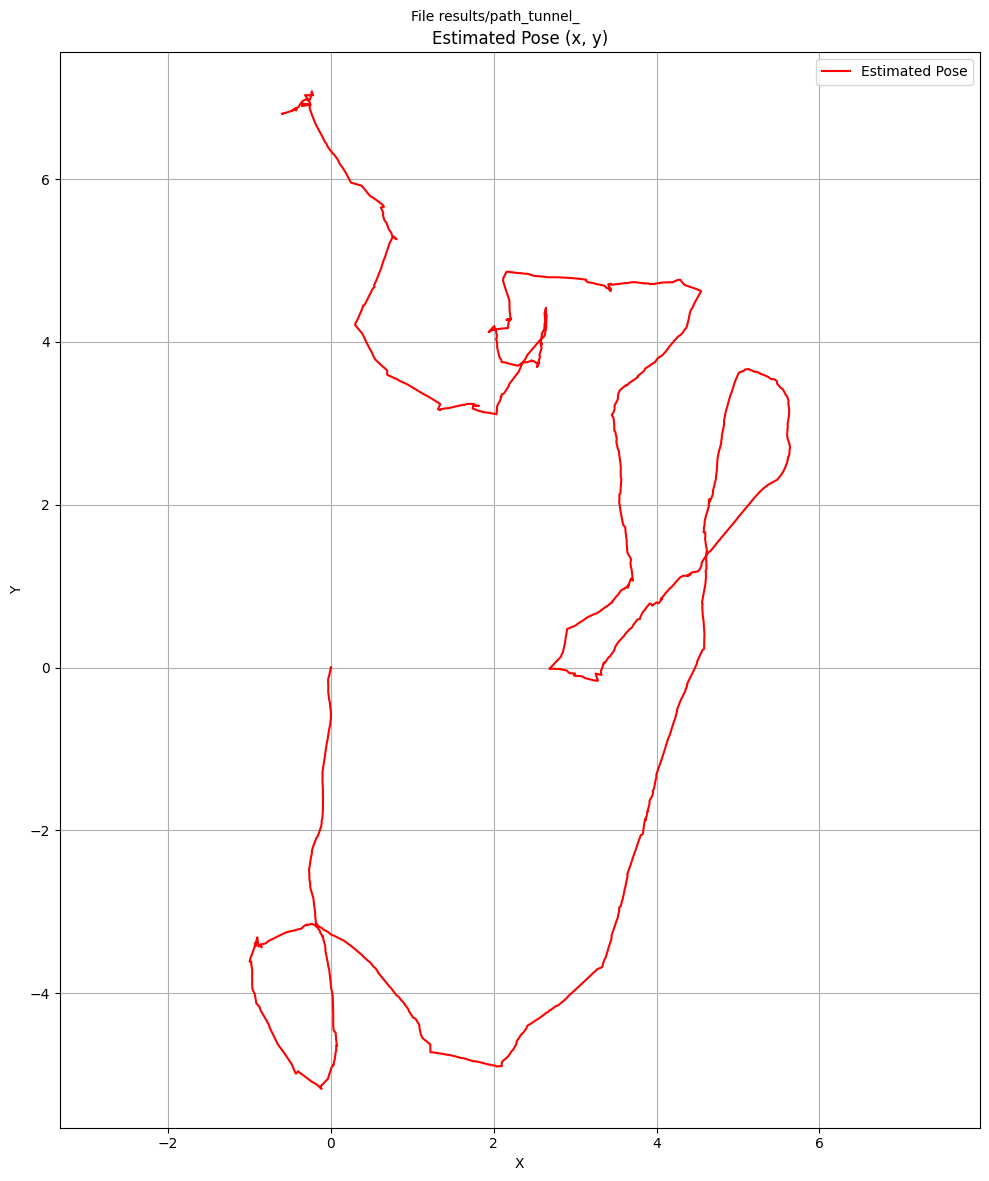

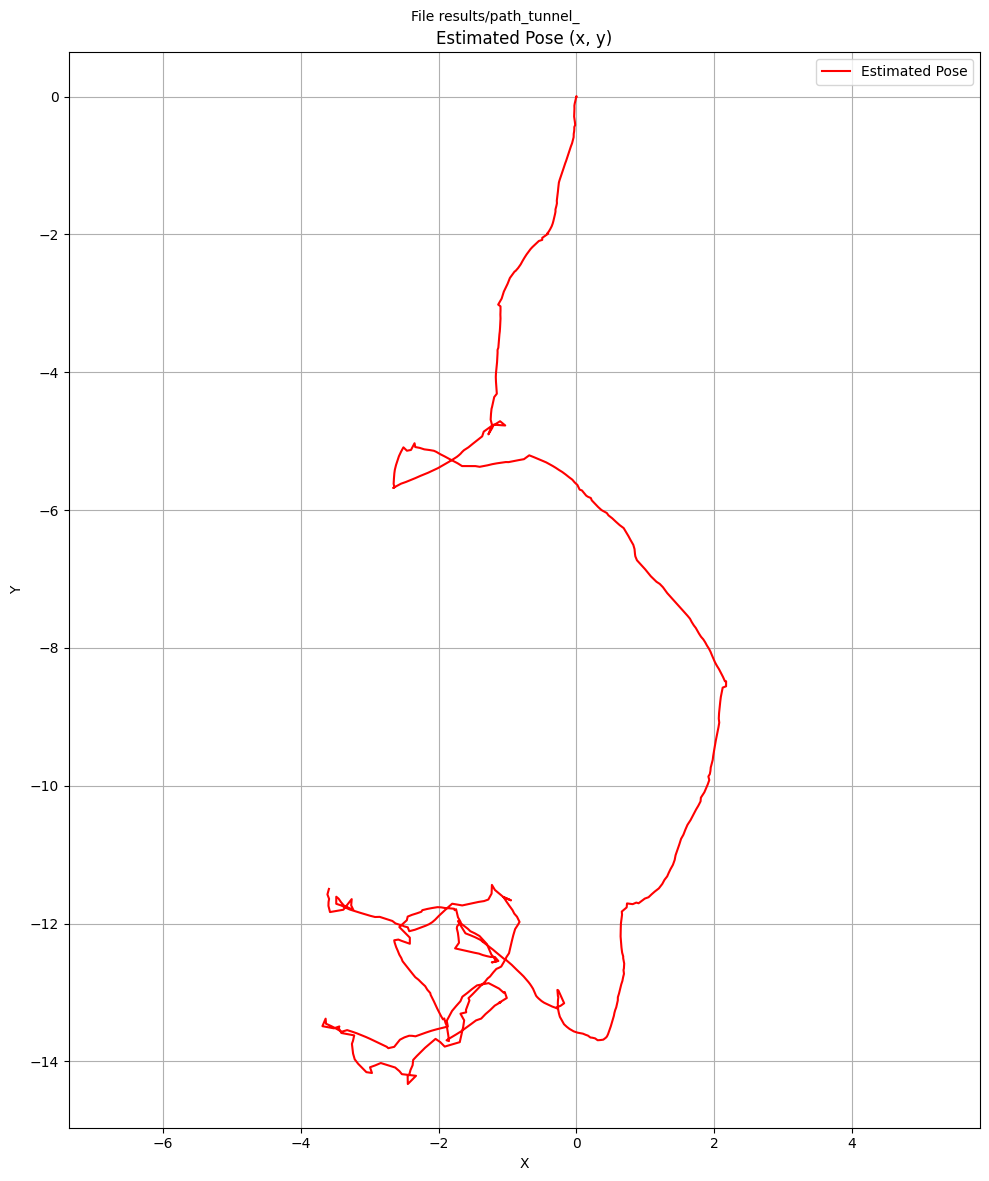

In [11]:
files = ['results/path_tunnel__window1.npy',
    'results/path_tunnel__window13.npy',
    'results/path_tunnel__window83.npy']

for i in files:
    plotResultsOnly(i, save=False)
    # break

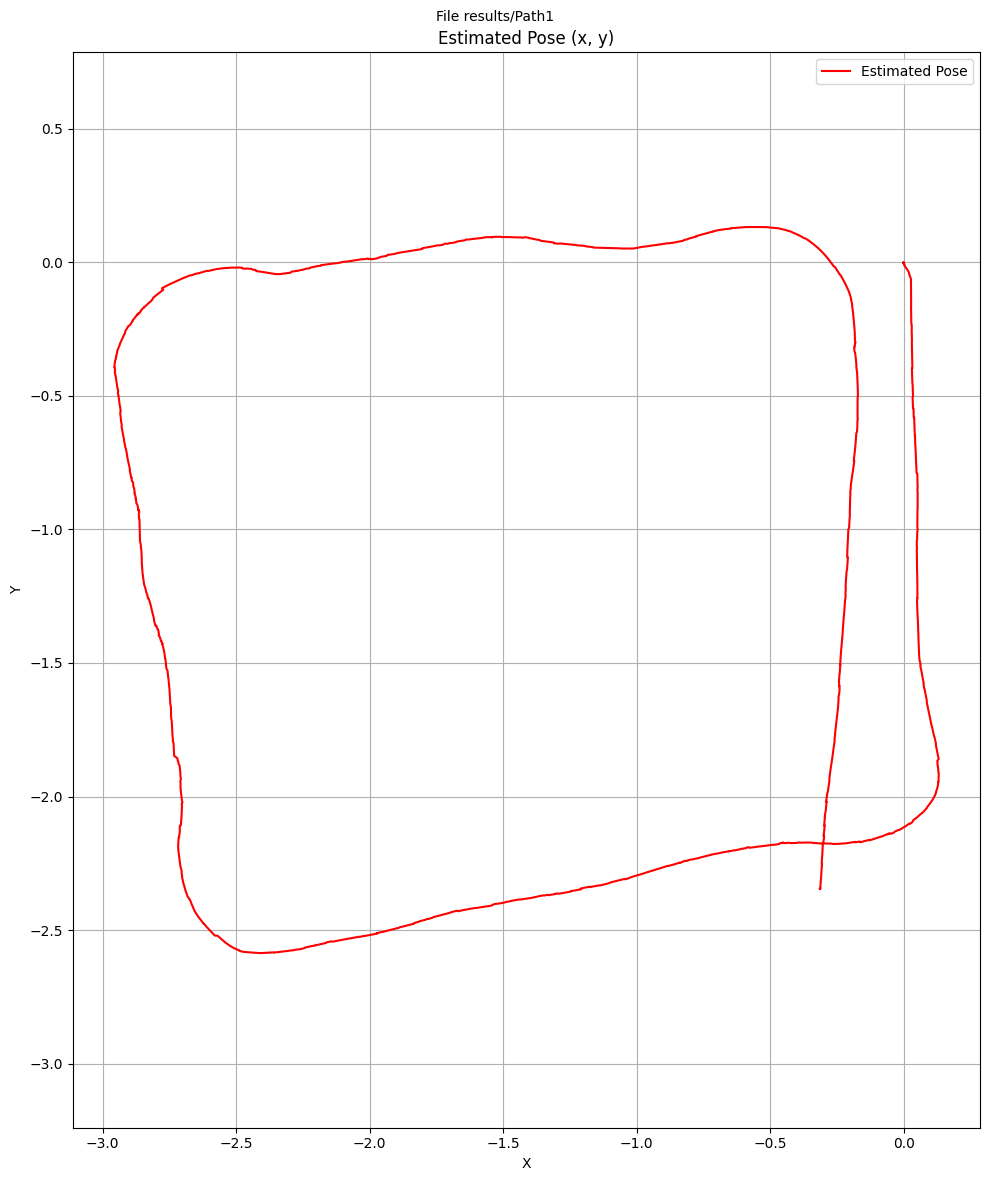

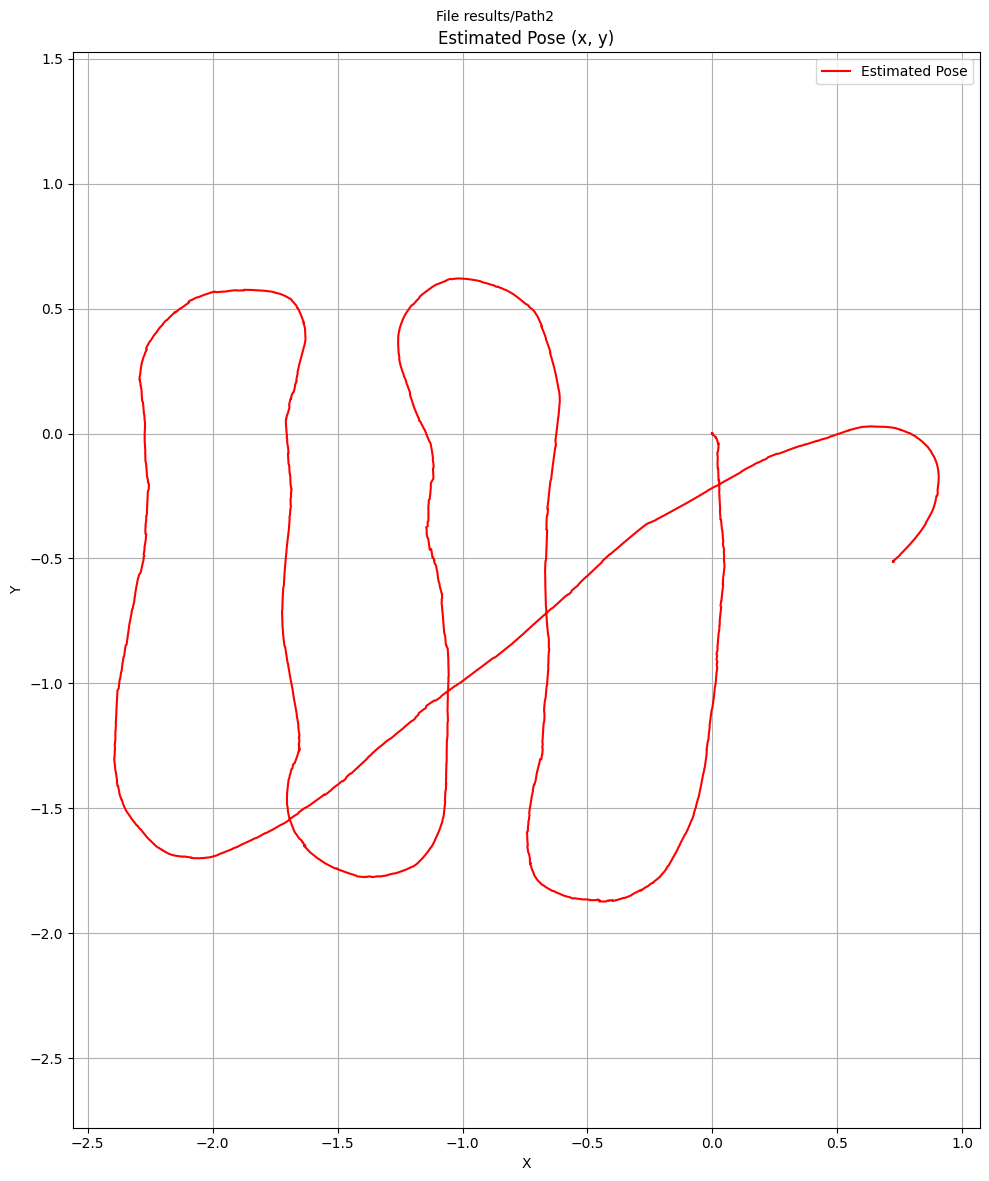

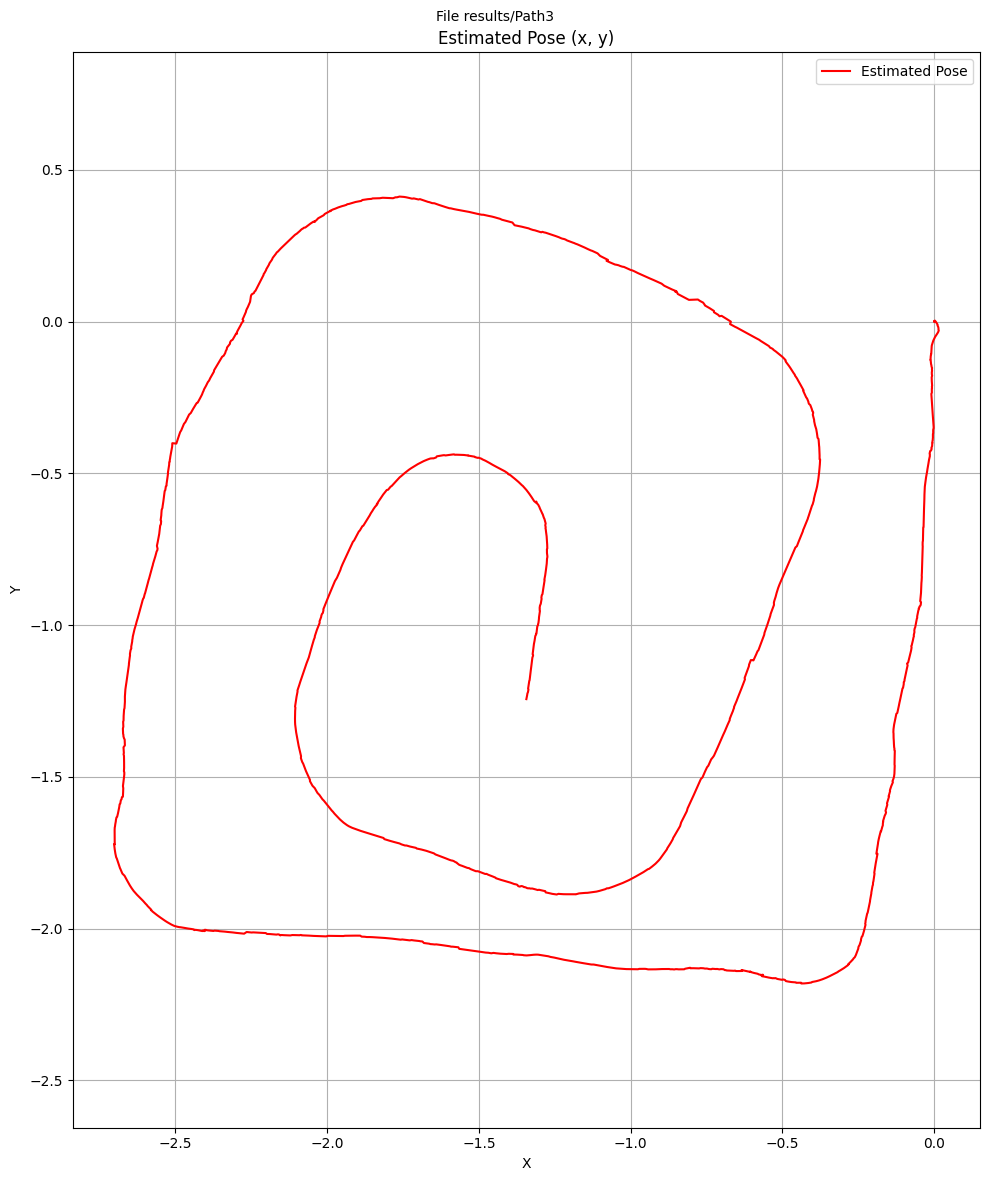

In [13]:
files = [
        'results/Path1_window25.npy',
        'results/Path2_window25.npy',
        'results/Path3_window25.npy',
        # 'results/Path4_window25.npy',
        # 'results/Path5_.npy'
        ]

for i in files:
    plotResultsOnly(i, save=False)

### Check if numpy and csv files exists

In [12]:
files = {'workroom_linoleum_test_path2' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path2.csv',
'workroom_linoleum_test_path4' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path4.csv',
'workroom_linoleum_test_path5' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path5.csv',
'workroom_linoleum_test_path6' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path6.csv',
'workroom_linoleum_test_path1' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path1.csv',
'workroom_linoleum_test_path3' : '/media/ajax/AJ/ground-slam/workroom_linoleum/test_path3.csv',
'garage_concrete_test_path5' : '/media/ajax/AJ/ground-slam/garage_concrete/test_path5.csv',
'garage_concrete_test_path3' : '/media/ajax/AJ/ground-slam/garage_concrete/test_path3.csv',
'checker_plate_steel_test_path2' : '/media/ajax/AJ/ground-slam/checker_plate_steel/test_path2.csv',
'checker_plate_steel_test_path1' : '/media/ajax/AJ/ground-slam/checker_plate_steel/test_path1.csv',
'office_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/office_test_sq/test_path1.csv',
'bathroom_tiles_test_path4' : '/media/ajax/AJ/ground-slam/bathroom_tiles/test_path4.csv',
'bathroom_tiles_test_path1' : '/media/ajax/AJ/ground-slam/bathroom_tiles/test_path1.csv',
'parking_place_test_sq_test_path2' : '/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path2.csv',
'parking_place_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path1.csv',
'footpath_test_sq_test_path2' : '/media/ajax/AJ/ground-slam/footpath_test_sq/test_path2.csv',
'footpath_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/footpath_test_sq/test_path1.csv',
'doormat_test_path1' : '/media/ajax/AJ/ground-slam/doormat/test_path1.csv',
'kitchen_test_sq_test_path2' : '/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path2.csv',
'kitchen_test_sq_test_path1' : '/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path1.csv',
}

for f in files:
    df = pd.read_csv(files[f])
    df.to_csv(f'{f}.csv')

In [13]:
npFiles = [
'_media_ajax_AJ_ground-slam_bathroom_tiles_test_path1_210814_seq0039.npy',
'_media_ajax_AJ_ground-slam_bathroom_tiles_test_path4_210814_seq0043.npy',
'_media_ajax_AJ_ground-slam_checker_plate_steel_test_path1_210814_seq0019.npy',
'_media_ajax_AJ_ground-slam_checker_plate_steel_test_path2_210814_seq0020.npy',
'_media_ajax_AJ_ground-slam_doormat_test_path1_seq0029.npy',
'_media_ajax_AJ_ground-slam_footpath_test_sq_test_path1_seq0027.npy',
'_media_ajax_AJ_ground-slam_footpath_test_sq_test_path2_seq0028.npy',
'_media_ajax_AJ_ground-slam_garage_concrete_test_path3_210809_seq0111.npy',
'_media_ajax_AJ_ground-slam_garage_concrete_test_path5_210809_seq0119.npy',
'_media_ajax_AJ_ground-slam_kitchen_test_sq_test_path1_seq0031.npy',
'_media_ajax_AJ_ground-slam_kitchen_test_sq_test_path2_seq0032.npy',
'_media_ajax_AJ_ground-slam_office_test_sq_test_path1_seq0029.npy',
'_media_ajax_AJ_ground-slam_parking_place_test_sq_test_path1_seq0028.npy',
'_media_ajax_AJ_ground-slam_parking_place_test_sq_test_path2_seq0029.npy',
'_media_ajax_AJ_ground-slam_workroom_linoleum_test_path1_210806_seq0079.npy',
'_media_ajax_AJ_ground-slam_workroom_linoleum_test_path2_210806_seq0080.npy',
'_media_ajax_AJ_ground-slam_workroom_linoleum_test_path3_210806_seq0081.npy',
'_media_ajax_AJ_ground-slam_workroom_linoleum_test_path4_210806_seq0082.npy',
'_media_ajax_AJ_ground-slam_workroom_linoleum_test_path5_210806_seq0083.npy',
'_media_ajax_AJ_ground-slam_workroom_linoleum_test_path6_210806_seq0084.npy']

csvFiles = ['/media/ajax/AJ/ground-slam/workroom_linoleum/test_path2.csv',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path4.csv',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path5.csv',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path6.csv',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path1.csv',
'/media/ajax/AJ/ground-slam/workroom_linoleum/test_path3.csv',
'/media/ajax/AJ/ground-slam/garage_concrete/test_path5.csv',
'/media/ajax/AJ/ground-slam/garage_concrete/test_path3.csv',
'/media/ajax/AJ/ground-slam/checker_plate_steel/test_path2.csv',
'/media/ajax/AJ/ground-slam/checker_plate_steel/test_path1.csv',
'/media/ajax/AJ/ground-slam/office_test_sq/test_path1.csv',
'/media/ajax/AJ/ground-slam/bathroom_tiles/test_path4.csv',
'/media/ajax/AJ/ground-slam/bathroom_tiles/test_path1.csv',
'/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path2.csv',
'/media/ajax/AJ/ground-slam/parking_place_test_sq/test_path1.csv',
'/media/ajax/AJ/ground-slam/footpath_test_sq/test_path2.csv',
'/media/ajax/AJ/ground-slam/footpath_test_sq/test_path1.csv',
'/media/ajax/AJ/ground-slam/doormat/test_path1.csv',
'/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path2.csv',
'/media/ajax/AJ/ground-slam/kitchen_test_sq/test_path1.csv',]

csvFiles.sort()
npFiles.sort()

for file_path in csvFiles:
    if not os.path.isfile(file_path):
        print(f"{file_path} is not a file or does not exist.")

for file_path in npFiles:
    if not os.path.isfile(file_path):
        print(f"{file_path} is not a file or does not exist.")

for i in range(len(npFiles)):
    print(f"{csvFiles[i]}--------{npFiles[i]}")

_media_ajax_AJ_ground-slam_bathroom_tiles_test_path1_210814_seq0039.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_bathroom_tiles_test_path4_210814_seq0043.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_checker_plate_steel_test_path1_210814_seq0019.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_checker_plate_steel_test_path2_210814_seq0020.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_doormat_test_path1_seq0029.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_footpath_test_sq_test_path1_seq0027.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_footpath_test_sq_test_path2_seq0028.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_garage_concrete_test_path3_210809_seq0111.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_garage_concrete_test_path5_210809_seq0119.npy is not a file or does not exist.
_media_ajax_AJ_ground-slam_kitchen_test_sq_test_path1_seq0031.npy i

## Plot for new datasets

In [33]:
def getTitle(filename):
    match = re.match(r"([a-zA-Z0-9_]+)_test_(.*?)_window(\d+)\.npy", filename)
    
    if match:
        env_name = match.group(1).replace('_',' ')
        path = match.group(2)
        window_size = match.group(3)
    
        # Construct the new format as per the requirement
        result = f"Results for {env_name} path number {path[-1]} with window size {window_size}"
        print(result)
    else:
        print(f"Filename {filename} format doesn't match expected pattern.")
        result = ''
    return result

In [24]:
import re

for filename in results:
    

Results for workroom linoleum path number 1 with window size 40
Results for workroom linoleum path number 2 with window size 30
Results for garage concrete path number 5 with window size 20
Results for checker plate steel path number 2 with window size 40
Results for workroom linoleum path number 6 with window size 20
Results for footpath test sq path number 2 with window size 30
Results for parking place test sq path number 1 with window size 40
Results for office test sq path number 1 with window size 30
Results for workroom linoleum path number 5 with window size 30
Results for bathroom tiles path number 4 with window size 10
Results for checker plate steel path number 2 with window size 10
Filename format doesn't match expected pattern.
Results for doormat path number 1 with window size 50
Results for kitchen test sq path number 1 with window size 50
Results for kitchen test sq path number 2 with window size 10
Results for footpath test sq path number 2 with window size 10
Results 

In [45]:
results = [i for i in os.listdir('results/') if i.endswith('.npy')]
results.sort()
seq = [i.split('_window')[0] for i in results]

for i,r in enumerate(results):
    if r.startswith('Path') or r.startswith('path'):
        print(f"Skipping {r}")
        continue

    # if r == 'parking_place_test_sq_test_path1_window20.npy':
    plotResults(files[seq[i]] ,'results/' + r, save=True, show=False)
    print(r)
    # break

Skipping Path1__window5.npy
Skipping Path1_window25.npy
Skipping Path2__window5.npy
Skipping Path2_window25.npy
Skipping Path3__window5.npy
Skipping Path3_window25.npy
Skipping Path4__window120.npy
Skipping Path4__window5.npy
Skipping Path4__window55.npy
Skipping Path4__window60.npy
Skipping Path4__window75.npy
Skipping Path4__window80.npy
Skipping Path4__window83.npy
Skipping Path4__window85.npy
Skipping Path4__window87.npy
Skipping Path4__window90.npy
Skipping Path4__window95.npy
Skipping Path4_window25.npy
Skipping Path5__window10.npy
Skipping Path5__window120.npy
Skipping Path5__window25.npy
Skipping Path5__window5.npy
Skipping Path5__window55.npy
Skipping Path5__window75.npy
Skipping Path5__window80.npy
Skipping Path5__window85.npy
Skipping Path5__window87.npy
Skipping Path5__window90.npy
Skipping Path5__window95.npy
Results for bathroom tiles path number 1 with window size 10
bathroom_tiles_test_path1_window10.npy
Results for bathroom tiles path number 1 with window size 20
bathr

## Plot for all files 1

In [ ]:
for i in range(20):
    plotResults(csvFiles[i],npFiles[i])

In [ ]:
i = 0
plotResults(csvFiles[i],npFiles[i],70)

In [ ]:
csvFile = '/media/ajax/AJ/ground-slam/bathroom_tiles/test_path1.csv'
npFile = 'test320_media_ajax_AJ_ground-slam_bathroom_tiles_test_path1_210814_seq0039.npy'
plotResults(csvFile,npFile,-1)

## Plot for all files 2

In [ ]:
results = ['results/' + i for i in os.listdir('results/checker_plate_steel_test_path1*')]
results.sort()

for i in range(20):
    plotResults(csvFiles[i],results[i])

### Plot for specific file

In [ ]:
files_starting_with_prefix = ['results/' + file for file in os.listdir('results/') if file.startswith('checker_plate_steel_test_path1')]
files_starting_with_prefix.sort()

for i in files_starting_with_prefix:
    plotResults(csvFiles[2],i)